### Monthly Milk Production Forecasting Using RNN, LSTM, and GRU Deep Learning Models

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.seasonal import seasonal_decompose


#### Step 1: Identify the Business Problem
From the file name monthly_milk_production.csv, it is clear that this dataset showing the monthly milk production of a dairy farm or industry.

Likely Business Problem

The business wants to forecast future milk production to:

•	Ensure proper supply chain and distribution planning.

•	Manage inventory and storage efficiently.

•	Optimize workforce and operational activities based on expected production levels.

•	Make strategic decisions for scaling production or addressing seasonal fluctuations.


#### Step 2: Define the Objective
Objective Statement:

The objective is to develop a time series forecasting model that accurately predicts the monthly milk production for the upcoming months. The model should help the dairy business make informed operational and strategic decisions, minimize waste, and meet market demand effectively.


In [11]:
csv_path = "monthly_milk_production.csv"   
date_col = "Date"                          
value_col = "Production"

#### Tasks

#### 1.	Exploratory Data Analysis (EDA)
o	Visualize trends, seasonality, and anomalies in the milk production data.
    
o	Check for any missing values or outliers.

o	Normalize or scale the data for neural network models.


In [12]:
df = pd.read_csv(csv_path)
df.shape

(168, 2)

In [13]:
def parse_yyyy_mm(x):
    if isinstance(x, str) and len(x.split("-")) == 2:
        return pd.to_datetime(x + "-01", format="%Y-%m-%d", errors='coerce')
    else:
        return pd.to_datetime(x, errors='coerce')

In [10]:
df.isna().sum()

Date          168
Production      0
dtype: int64

In [14]:
df[date_col] = df[date_col].apply(parse_yyyy_mm)


In [15]:
df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

In [16]:
df = df.dropna(subset=[date_col, value_col]).reset_index(drop=True)

In [17]:
df = df.sort_values(date_col).reset_index(drop=True)
df[date_col] = pd.DatetimeIndex(df[date_col]).to_period('M').to_timestamp()  # normalize to month start
df.set_index(date_col, inplace=True)

In [18]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [19]:
df.isna().sum()

Production    0
dtype: int64

In [20]:
if df[value_col].isna().any():
    df[value_col] = df[value_col].ffill().bfill()

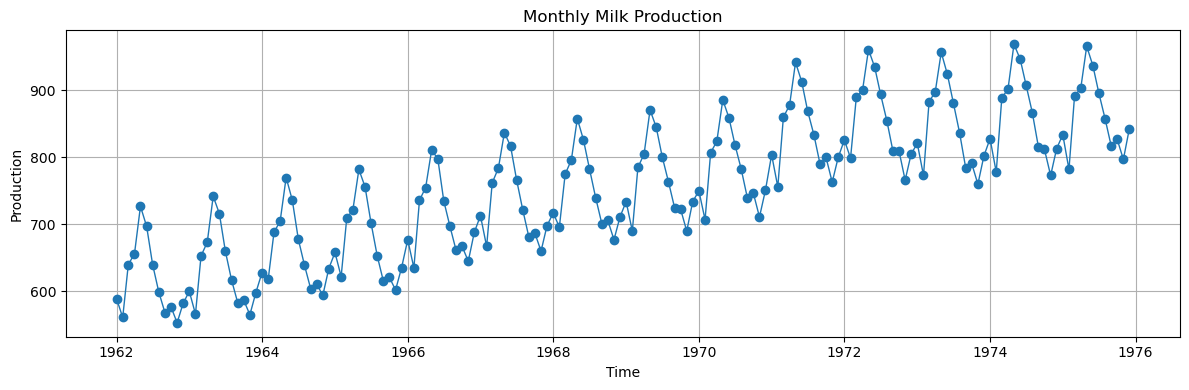

In [55]:
plt.figure(figsize=(12,4))
plt.plot(df[value_col], marker='o', linewidth=1)
plt.title("Monthly Milk Production")
plt.ylabel(value_col)
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

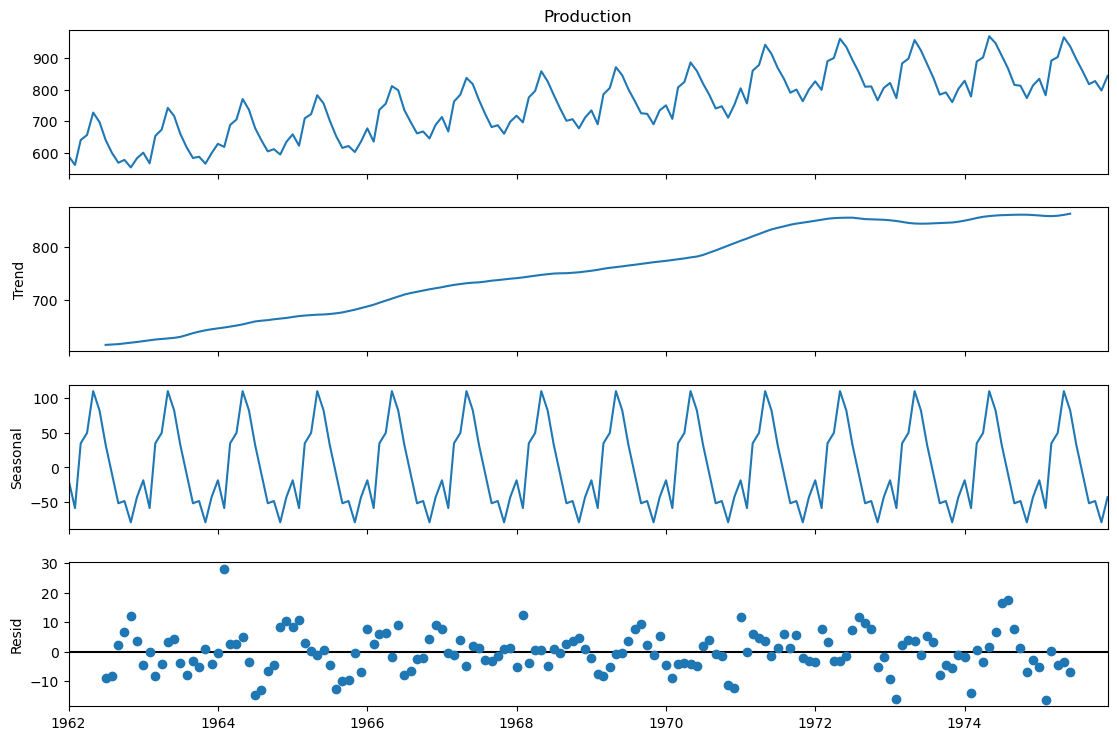

In [23]:
if isinstance(df.index, pd.DatetimeIndex) and len(df) >= 24:
    try:
        decomposition = seasonal_decompose(df[value_col], model="additive", period=12)
        fig = decomposition.plot()
        fig.set_size_inches(12,8)
        plt.show()
    except Exception as e:
        print("Seasonal decomposition failed:", e)

In [24]:
q1 = df[value_col].quantile(0.25)
q3 = df[value_col].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = df[(df[value_col] < lower) | (df[value_col] > upper)]
print(f"Outliers detected: {len(outliers)} rows")
if len(outliers) > 0:
    print(outliers)

Outliers detected: 0 rows


#### 2.	Data Preparation for Deep Learning
o	Create input-output sequences (time windows) suitable for training RNNs/LSTMs/GRUs.
                                                         
o	Split data into training, validation, and test sets.
    
o	Reshape data for model input dimensions.


In [26]:
series = df[value_col].values.reshape(-1, 1)

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
series_scaled = scaler.fit_transform(series)

In [28]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

In [29]:
WINDOW = 12        
BATCH_SIZE = 16
EPOCHS = 200
VAL_SPLIT = 0.15    
TEST_SIZE = 24

In [30]:
X_all, y_all = create_sequences(series_scaled, WINDOW)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)

X_all shape: (156, 12, 1) y_all shape: (156, 1)


In [31]:
train_val_end = len(series_scaled) - TEST_SIZE

In [32]:
split_index = train_val_end - WINDOW
if split_index <= 0:
    raise ValueError("Not enough data for the chosen WINDOW and TEST_SIZE. Reduce them.")

In [33]:
X_train_val = X_all[:split_index]
y_train_val = y_all[:split_index]
X_test = X_all[split_index:]
y_test = y_all[split_index:]

In [34]:
val_fraction = VAL_SPLIT
val_n = int(len(X_train_val) * val_fraction)
X_train = X_train_val[:-val_n] if val_n>0 else X_train_val
y_train = y_train_val[:-val_n] if val_n>0 else y_train_val
X_val = X_train_val[-val_n:] if val_n>0 else np.empty((0,)+X_train.shape[1:])
y_val = y_train_val[-val_n:] if val_n>0 else np.empty((0,)+y_train.shape[1:])

In [35]:
print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


Shapes -> X_train: (113, 12, 1) X_val: (19, 12, 1) X_test: (24, 12, 1)


#### 3.	Model Building
o	Build three separate models:

	Basic RNN

	LSTM

	GRU

o	Tune hyperparameters (e.g., window size, number of units, batch size, epochs).

o	Use appropriate loss functions and optimizers.


In [36]:
def build_rnn(window, units=32):
    model = Sequential([
        SimpleRNN(units, input_shape=(window, 1), activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [37]:
def build_lstm(window, units=32):
    model = Sequential([
        LSTM(units, input_shape=(window, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [38]:
def build_gru(window, units=32):
    model = Sequential([
        GRU(units, input_shape=(window, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### 4.	Model Evaluation
o	Plot predictions vs. actual values.

o	Calculate forecasting metrics: RMSE, MAE, MAPE.

o	Compare the performance of RNN, LSTM, and GRU.


In [45]:
def train_and_evaluate(model_builder, name, units=32, epochs=EPOCHS):
    print(f"\n--- Training {name} (units={units}) ---")
    model = model_builder(WINDOW, units=units)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1)
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val) if X_val.shape[0]>0 else None,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=2
    )
    y_pred_test = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    y_pred_test_inv = scaler.inverse_transform(y_pred_test).flatten()

    rmse = sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_test_inv) / np.where(y_test_inv==0, 1e-8, y_test_inv))) * 100
    print(f"{name} Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,4))
    if isinstance(df.index, pd.DatetimeIndex):
        test_start_idx = len(series) - TEST_SIZE
        timeline = df.index[-len(y_test):]
        plt.plot(timeline, y_test_inv, label='Actual', marker='o')
        plt.plot(timeline, y_pred_test_inv, label=f'Predicted ({name})', marker='o')
        plt.xlabel("Time")
    else:
        plt.plot(y_test_inv, label='Actual', marker='o')
        plt.plot(y_pred_test_inv, label=f'Predicted ({name})', marker='o')
        plt.xlabel("Index")
    plt.title(f"Actual vs Predicted - {name}")
    plt.ylabel(value_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, history, (rmse, mae, mape), (y_test_inv, y_pred_test_inv)

In [46]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1)) if X_val.shape[0]>0 else X_val
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


--- Training SimpleRNN (units=32) ---
Epoch 1/200
8/8 - 4s - 506ms/step - loss: 0.5002 - val_loss: 0.1617 - learning_rate: 1.0000e-03
Epoch 2/200
8/8 - 1s - 78ms/step - loss: 0.0481 - val_loss: 0.0109 - learning_rate: 1.0000e-03
Epoch 3/200
8/8 - 0s - 34ms/step - loss: 0.0500 - val_loss: 0.0175 - learning_rate: 1.0000e-03
Epoch 4/200
8/8 - 0s - 47ms/step - loss: 0.0182 - val_loss: 0.0594 - learning_rate: 1.0000e-03
Epoch 5/200
8/8 - 0s - 38ms/step - loss: 0.0201 - val_loss: 0.0474 - learning_rate: 1.0000e-03
Epoch 6/200
8/8 - 0s - 39ms/step - loss: 0.0125 - val_loss: 0.0148 - learning_rate: 1.0000e-03
Epoch 7/200
8/8 - 0s - 45ms/step - loss: 0.0099 - val_loss: 0.0108 - learning_rate: 1.0000e-03
Epoch 8/200
8/8 - 0s - 38ms/step - loss: 0.0080 - val_loss: 0.0119 - learning_rate: 1.0000e-03
Epoch 9/200
8/8 - 0s - 36ms/step - loss: 0.0066 - val_loss: 0.0122 - learning_rate: 1.0000e-03
Epoch 10/200
8/8 - 0s - 42ms/step - loss: 0.0057 - val_loss: 0.0123 - learning_rate: 1.0000e-03
Epoch 11/

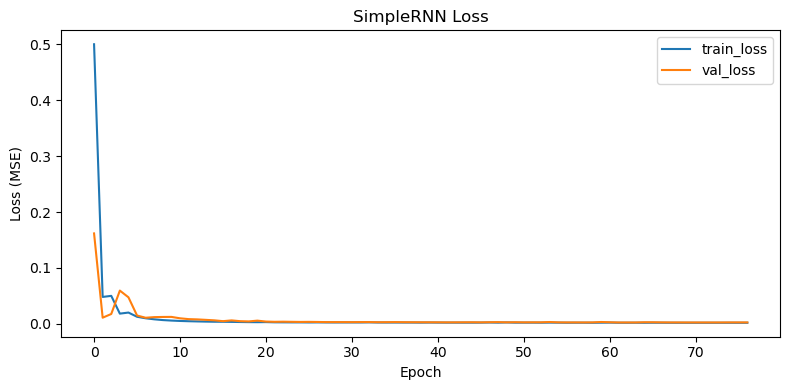

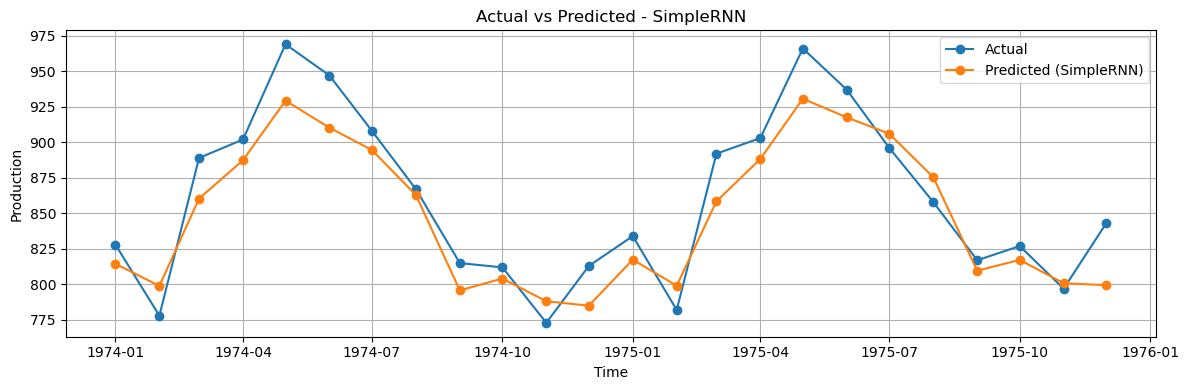


--- Training LSTM (units=64) ---
Epoch 1/200
8/8 - 5s - 580ms/step - loss: 0.1687 - val_loss: 0.1121 - learning_rate: 1.0000e-03
Epoch 2/200
8/8 - 1s - 80ms/step - loss: 0.0370 - val_loss: 0.0512 - learning_rate: 1.0000e-03
Epoch 3/200
8/8 - 0s - 46ms/step - loss: 0.0325 - val_loss: 0.0246 - learning_rate: 1.0000e-03
Epoch 4/200
8/8 - 0s - 38ms/step - loss: 0.0278 - val_loss: 0.0353 - learning_rate: 1.0000e-03
Epoch 5/200
8/8 - 0s - 41ms/step - loss: 0.0284 - val_loss: 0.0259 - learning_rate: 1.0000e-03
Epoch 6/200
8/8 - 0s - 37ms/step - loss: 0.0251 - val_loss: 0.0242 - learning_rate: 1.0000e-03
Epoch 7/200
8/8 - 0s - 42ms/step - loss: 0.0250 - val_loss: 0.0231 - learning_rate: 1.0000e-03
Epoch 8/200
8/8 - 0s - 42ms/step - loss: 0.0243 - val_loss: 0.0234 - learning_rate: 1.0000e-03
Epoch 9/200
8/8 - 0s - 41ms/step - loss: 0.0255 - val_loss: 0.0263 - learning_rate: 1.0000e-03
Epoch 10/200
8/8 - 1s - 81ms/step - loss: 0.0228 - val_loss: 0.0219 - learning_rate: 1.0000e-03
Epoch 11/200
8

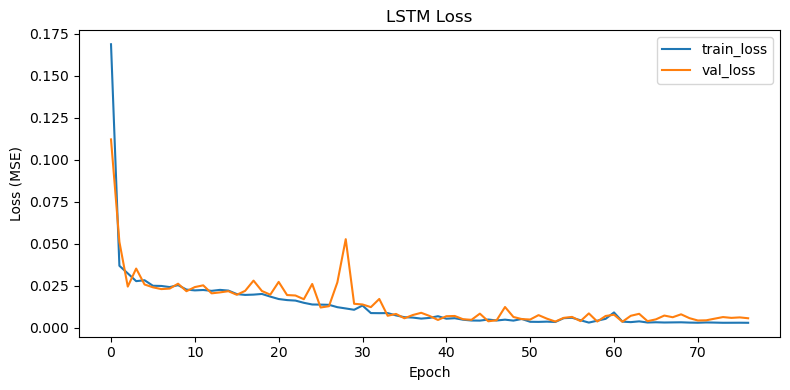

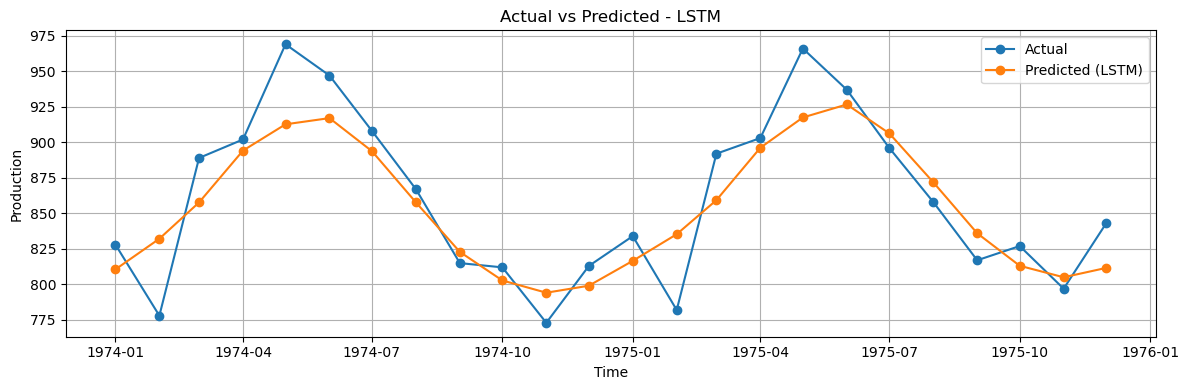


--- Training GRU (units=64) ---
Epoch 1/200
8/8 - 6s - 720ms/step - loss: 0.1230 - val_loss: 0.0606 - learning_rate: 1.0000e-03
Epoch 2/200
8/8 - 0s - 39ms/step - loss: 0.0334 - val_loss: 0.0295 - learning_rate: 1.0000e-03
Epoch 3/200
8/8 - 0s - 43ms/step - loss: 0.0324 - val_loss: 0.0207 - learning_rate: 1.0000e-03
Epoch 4/200
8/8 - 0s - 43ms/step - loss: 0.0248 - val_loss: 0.0269 - learning_rate: 1.0000e-03
Epoch 5/200
8/8 - 0s - 53ms/step - loss: 0.0261 - val_loss: 0.0298 - learning_rate: 1.0000e-03
Epoch 6/200
8/8 - 0s - 37ms/step - loss: 0.0239 - val_loss: 0.0230 - learning_rate: 1.0000e-03
Epoch 7/200
8/8 - 0s - 42ms/step - loss: 0.0226 - val_loss: 0.0193 - learning_rate: 1.0000e-03
Epoch 8/200
8/8 - 0s - 40ms/step - loss: 0.0215 - val_loss: 0.0191 - learning_rate: 1.0000e-03
Epoch 9/200
8/8 - 0s - 50ms/step - loss: 0.0208 - val_loss: 0.0186 - learning_rate: 1.0000e-03
Epoch 10/200
8/8 - 0s - 39ms/step - loss: 0.0205 - val_loss: 0.0196 - learning_rate: 1.0000e-03
Epoch 11/200
8/

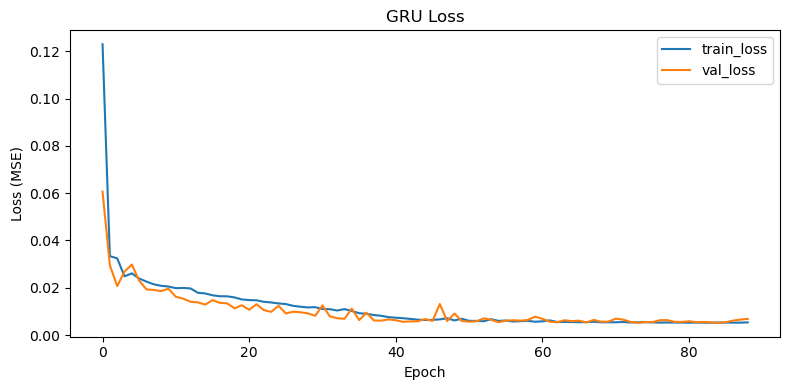

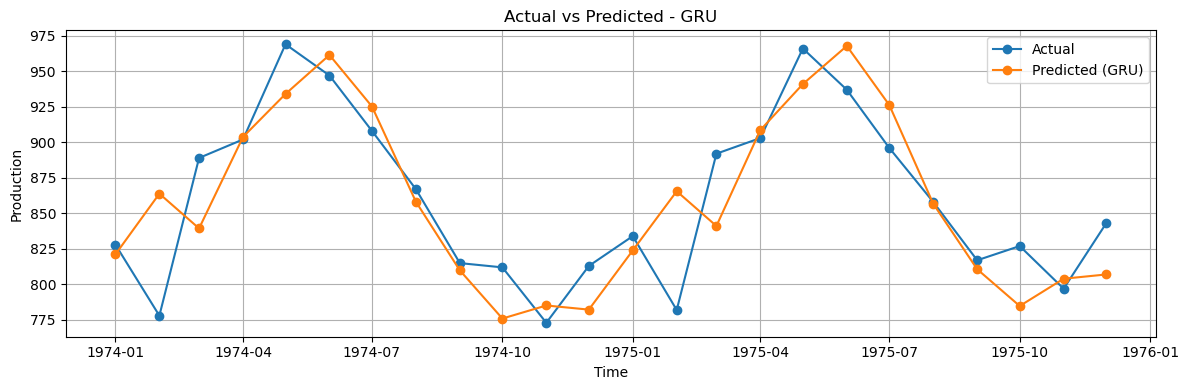

In [47]:
rnn_model, rnn_hist, rnn_metrics, rnn_preds = train_and_evaluate(build_rnn, "SimpleRNN", units=32)
lstm_model, lstm_hist, lstm_metrics, lstm_preds = train_and_evaluate(build_lstm, "LSTM", units=64)
gru_model, gru_hist, gru_metrics, gru_preds = train_and_evaluate(build_gru, "GRU", units=64)

In [48]:
summary = pd.DataFrame({
    "Model": ["SimpleRNN", "LSTM", "GRU"],
    "RMSE": [rnn_metrics[0], lstm_metrics[0], gru_metrics[0]],
    "MAE": [rnn_metrics[1], lstm_metrics[1], gru_metrics[1]],
    "MAPE(%)": [rnn_metrics[2], lstm_metrics[2], gru_metrics[2]]
})


In [49]:
summary

,Model,RMSE,MAE,MAPE(%)
0,SimpleRNN,22.556590,19.597341,2.248808
1,LSTM,27.425223,22.428965,2.607424
2,GRU,35.035532,26.351056,3.113970


In [50]:
best_idx = summary['RMSE'].idxmin()
best_model_name = summary.loc[best_idx, 'Model']
print(f"\nBest model by RMSE: {best_model_name}")
best_model = {'SimpleRNN': rnn_model, 'LSTM': lstm_model, 'GRU': gru_model}[best_model_name]


Best model by RMSE: SimpleRNN


#### 5.	Prediction and Visualization
o	Forecast milk production for the next 12 months.

o	Visualize the predicted trend with uncertainty or confidence intervals if possible.


In [51]:
def forecast_recursive(model, input_series_scaled, n_steps, window):
    history = input_series_scaled[-window:].reshape(1, window, 1).copy()
    forecast_scaled = []
    for _ in range(n_steps):
        yhat = model.predict(history)
        forecast_scaled.append(yhat.flatten()[0])
        new_step = np.array(yhat).reshape(1,1,1)
        history = np.concatenate([history[:,1:,:], new_step], axis=1)
    return np.array(forecast_scaled).reshape(-1,1)

In [52]:
n_forecast = 12
fc_scaled = forecast_recursive(best_model, series_scaled, n_forecast, WINDOW)
fc = scaler.inverse_transform(fc_scaled).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


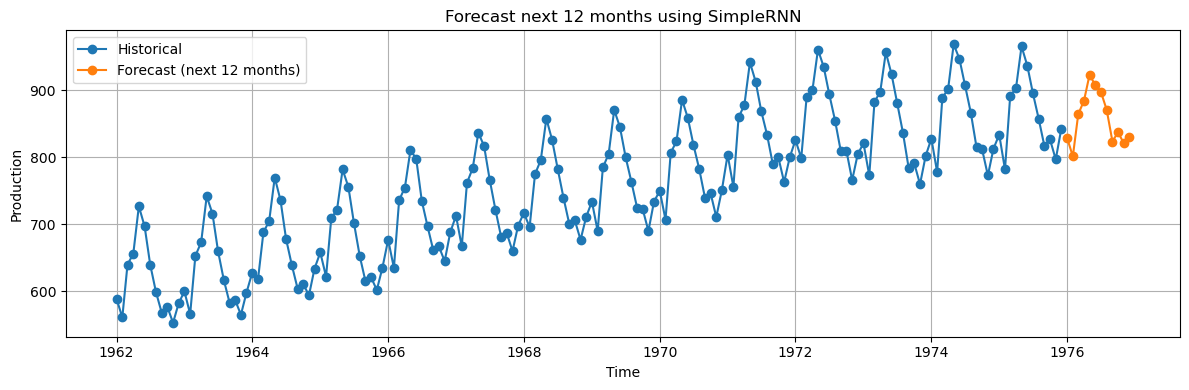

In [53]:
if isinstance(df.index, pd.DatetimeIndex):
    last_date = df.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df[value_col], label='Historical', marker='o')
    plt.plot(forecast_index, fc, label='Forecast (next 12 months)', marker='o')
    plt.title(f"Forecast next {n_forecast} months using {best_model_name}")
    plt.xlabel("Time")
    plt.ylabel(value_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(10,4))
    plt.plot(np.arange(len(series)), series.flatten(), label='Historical')
    plt.plot(np.arange(len(series), len(series)+n_forecast), fc, label='Forecast')
    plt.legend()
    plt.show()

In [54]:
print("\nBusiness insights / recommendations:")
print("- Use the forecast to inform procurement and storage decisions.")
print("- If seasonality is strong (see decomposition), plan for peak months in advance.")
print("- Compare LSTM/GRU results; choose the best model but monitor retraining frequency (monthly/quarterly).")
print("- Consider adding exogenous variables (temperature, feed cost, holidays) for improved accuracy.")
print("- Track prediction intervals and use safety buffers when ordering perishable supplies.")


Business insights / recommendations:
- Use the forecast to inform procurement and storage decisions.
- If seasonality is strong (see decomposition), plan for peak months in advance.
- Compare LSTM/GRU results; choose the best model but monitor retraining frequency (monthly/quarterly).
- Consider adding exogenous variables (temperature, feed cost, holidays) for improved accuracy.
- Track prediction intervals and use safety buffers when ordering perishable supplies.
